In [1]:
import yfinance as yf
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Downlod Google Stock Value

In [2]:
# Define the stock symbol (ticker)
stock_symbol = 'GOOGL'

# Define the time period for which you want to download stock data
start_date = '2010-01-01'
end_date = '2023-01-01'

# Download historical stock data
stock_data = yf.download(stock_symbol, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [3]:
# Head of stock data
stock_data.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,15.689439,15.753504,15.621622,15.684434,15.684434,78169752
2010-01-05,15.695195,15.711712,15.554054,15.615365,15.615365,120067812
2010-01-06,15.662162,15.662162,15.174174,15.221722,15.221722,158988852
2010-01-07,15.250250,15.265265,14.831081,14.867367,14.867367,256315428
2010-01-08,14.814815,15.096346,14.742492,15.065566,15.065566,188783028


#### PLot Closing prices

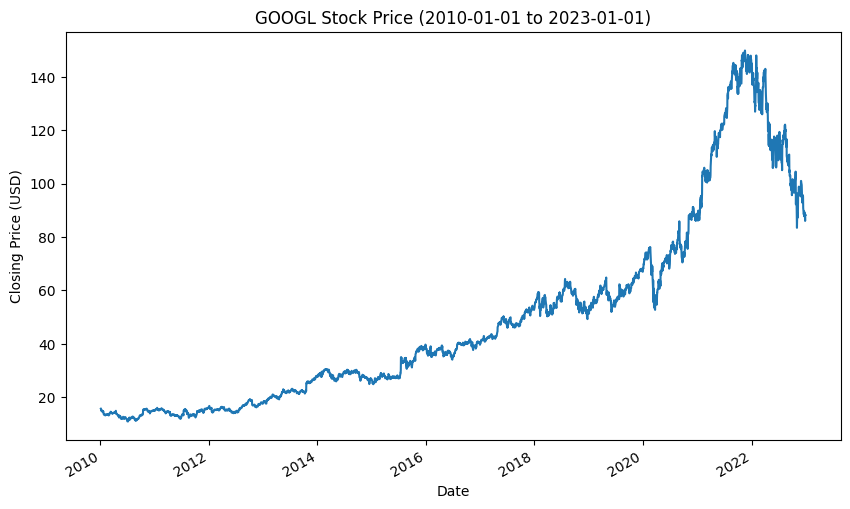

In [4]:
plt.figure(figsize=(10, 6))
stock_data['Close'].plot(title=f'{stock_symbol} Stock Price ({start_date} to {end_date})')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.show()

# Train , Validation Split of data

In [5]:
# number of samples
N = len(stock_data)

# number of training samples
N_train = int(np.floor(0.8*N))

In [6]:
def time_series_data(df, N_train,X_steps, y_steps):
    train_df = df.iloc[:N_train].Close.values.reshape(-1, 1)
    test_df = df.iloc[N_train:].Close.values.reshape(-1, 1)

    sc = MinMaxScaler(feature_range=(0, 1))
    train_df_scaled = sc.fit_transform(train_df)

    X_train = []
    y_train = []
    for i in range(X_steps, len(train_df_scaled)-y_steps+1):
        X_train.append(train_df_scaled[i-X_steps:i, 0])
        y_train.append(train_df_scaled[i:i+y_steps, 0])

    X_train = np.array(X_train)
    y_train = np.array(y_train)

    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

    X = df.Close.values
    X = X[len(X)-len(test_df)-X_steps:]
    X = X.reshape(-1, 1)
    X = sc.transform(X)

    X_test = []
    y_test = []

    for i in range(X_steps, len(test_df)+X_steps-y_steps+1):
        X_test.append(X[i-X_steps:i, 0])
        y_test.append(X[i:i+y_steps, 0])

    X_test = np.array(X_test)
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    y_test = np.array(y_test)

    return X_train, y_train, X_test, y_test, sc

In [7]:
X_train, y_train,X_val,y_val ,sc = time_series_data(stock_data,N_train,6,2)

# Simple RNN Model

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

In [9]:
!pip install keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 1.4 MB/s eta 0:00:00


In [10]:
import keras_tuner as kt

In [ ]:
def model_builder(hp):
  model = Sequential()
  model.add(SimpleRNN(units=hp.Int("units", min_value=10, max_value=200, step=10),return_sequences=True))
  model.add(SimpleRNN(units=hp.Int("units", min_value=10, max_value=200, step=10),return_sequences=True))
  model.add(SimpleRNN(units=hp.Int("units", min_value=10, max_value=200, step=10)))
  model.add(Dense(2))
  model.compile(optimizer="adam",loss="mean_absolute_error")
  return model

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

Reloading Tuner from my_dir/intro_to_kt/tuner0.json


In [15]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
tuner.search(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[stop_early])

Trial 23 Complete [00h 00m 44s]
val_loss: 0.07167913764715195

Best val_loss So Far: 0.020663194358348846
Total elapsed time: 00h 11m 29s


In [ ]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units is {best_hps.get('units')}""")


The hyperparameter search is complete. The optimal number of units is 200


In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val,y_val))

val_loss_per_epoch = history.history['val_loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
82/82 [==============================] - 5s 23ms/step - loss: 0.1660 - val_loss: 0.3473
Epoch 2/50
82/82 [==============================] - 2s 19ms/step - loss: 0.0223 - val_loss: 0.1714
Epoch 3/50
82/82 [==============================] - 2s 20ms/step - loss: 0.0200 - val_loss: 0.1354
Epoch 4/50
82/82 [==============================] - 2s 19ms/step - loss: 0.0148 - val_loss: 0.0714
Epoch 5/50
82/82 [==============================] - 1s 18ms/step - loss: 0.0147 - val_loss: 0.0528
Epoch 6/50
82/82 [==============================] - 3s 36ms/step - loss: 0.0139 - val_loss: 0.0644
Epoch 7/50
82/82 [==============================] - 2s 20ms/step - loss: 0.0125 - val_loss: 0.1130
Epoch 8/50
82/82 [==============================] - 2s 20ms/step - loss: 0.0138 - val_loss: 0.0765
Epoch 9/50
82/82 [==============================] - 2s 20ms/step - loss: 0.0102 - val_loss: 0.0679
Epoch 10/50
82/82 [==============================] - 2s 19ms/step - loss: 0.0095 - val_loss: 0.1279
Epoch 11/

In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
history_rnn = hypermodel.fit(X_train, y_train, epochs=best_epoch, validation_data=(X_val,y_val))

Epoch 1/20
82/82 [==============================] - 5s 24ms/step - loss: 0.1316 - val_loss: 0.3404
Epoch 2/20
82/82 [==============================] - 2s 23ms/step - loss: 0.0231 - val_loss: 0.2057
Epoch 3/20
82/82 [==============================] - 4s 48ms/step - loss: 0.0170 - val_loss: 0.1527
Epoch 4/20
82/82 [==============================] - 2s 19ms/step - loss: 0.0153 - val_loss: 0.0866
Epoch 5/20
82/82 [==============================] - 3s 31ms/step - loss: 0.0122 - val_loss: 0.1077
Epoch 6/20
82/82 [==============================] - 2s 28ms/step - loss: 0.0123 - val_loss: 0.1015
Epoch 7/20
82/82 [==============================] - 2s 20ms/step - loss: 0.0120 - val_loss: 0.1411
Epoch 8/20
82/82 [==============================] - 2s 28ms/step - loss: 0.0101 - val_loss: 0.0822
Epoch 9/20
82/82 [==============================] - 3s 40ms/step - loss: 0.0104 - val_loss: 0.0594
Epoch 10/20
82/82 [==============================] - 2s 27ms/step - loss: 0.0117 - val_loss: 0.0617
Epoch 11/

# LSTM

In [23]:
from tensorflow.keras.layers import LSTM

In [ ]:
def model_builder_lstm(hp):
  model = Sequential()
  model.add(LSTM(units=hp.Int("units", min_value=10, max_value=200, step=10),return_sequences=True))
  model.add(LSTM(units=hp.Int("units", min_value=10, max_value=200, step=10),return_sequences=True))
  model.add(LSTM(units=hp.Int("units", min_value=10, max_value=200, step=10)))
  model.add(Dense(2))
  model.compile(optimizer="adam",loss="mean_absolute_error")
  return model

In [ ]:
tuner_lstm = kt.Hyperband(model_builder_lstm,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='lstm')

In [ ]:
tuner_lstm.search(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[stop_early])

Trial 28 Complete [00h 00m 14s]
val_loss: 0.10210084170103073

Best val_loss So Far: 0.06305500119924545
Total elapsed time: 00h 05m 27s


In [ ]:
# Get the optimal hyperparameters
best_hps=tuner_lstm.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units is {best_hps.get('units')}""")


The hyperparameter search is complete. The optimal number of units is 200


In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner_lstm.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val,y_val))

val_loss_per_epoch = history.history['val_loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
82/82 [==============================] - 8s 20ms/step - loss: 0.0472 - val_loss: 0.2745
Epoch 2/50
82/82 [==============================] - 1s 8ms/step - loss: 0.0192 - val_loss: 0.1185
Epoch 3/50
82/82 [==============================] - 1s 8ms/step - loss: 0.0139 - val_loss: 0.1065
Epoch 4/50
82/82 [==============================] - 1s 8ms/step - loss: 0.0190 - val_loss: 0.0962
Epoch 5/50
82/82 [==============================] - 1s 8ms/step - loss: 0.0144 - val_loss: 0.1071
Epoch 6/50
82/82 [==============================] - 1s 9ms/step - loss: 0.0144 - val_loss: 0.1064
Epoch 7/50
82/82 [==============================] - 1s 8ms/step - loss: 0.0137 - val_loss: 0.1031
Epoch 8/50
82/82 [==============================] - 1s 8ms/step - loss: 0.0177 - val_loss: 0.1004
Epoch 9/50
82/82 [==============================] - 1s 8ms/step - loss: 0.0149 - val_loss: 0.0837
Epoch 10/50
82/82 [==============================] - 1s 9ms/step - loss: 0.0135 - val_loss: 0.0784
Epoch 11/50
82/82 

In [ ]:
hypermodel = tuner_lstm.hypermodel.build(best_hps)

# Retrain the model
history_lstm = hypermodel.fit(X_train, y_train, epochs=best_epoch, validation_data=(X_val,y_val))

Epoch 1/39
82/82 [==============================] - 7s 19ms/step - loss: 0.0470 - val_loss: 0.0838
Epoch 2/39
82/82 [==============================] - 1s 8ms/step - loss: 0.0164 - val_loss: 0.0733
Epoch 3/39
82/82 [==============================] - 1s 8ms/step - loss: 0.0167 - val_loss: 0.1136
Epoch 4/39
82/82 [==============================] - 1s 8ms/step - loss: 0.0151 - val_loss: 0.1235
Epoch 5/39
82/82 [==============================] - 1s 8ms/step - loss: 0.0133 - val_loss: 0.1086
Epoch 6/39
82/82 [==============================] - 1s 10ms/step - loss: 0.0146 - val_loss: 0.0863
Epoch 7/39
82/82 [==============================] - 1s 10ms/step - loss: 0.0142 - val_loss: 0.0793
Epoch 8/39
82/82 [==============================] - 1s 12ms/step - loss: 0.0136 - val_loss: 0.1061
Epoch 9/39
82/82 [==============================] - 1s 9ms/step - loss: 0.0134 - val_loss: 0.1020
Epoch 10/39
82/82 [==============================] - 1s 9ms/step - loss: 0.0135 - val_loss: 0.0773
Epoch 11/39
82/

# GRU

In [11]:
from tensorflow.keras.layers import GRU

In [12]:
def model_builder_gru(hp):
  model = Sequential()
  model.add(GRU(units=hp.Int("units", min_value=10, max_value=200, step=10),return_sequences=True))
  model.add(GRU(units=hp.Int("units", min_value=10, max_value=200, step=10),return_sequences=True))
  model.add(GRU(units=hp.Int("units", min_value=10, max_value=200, step=10)))
  model.add(Dense(2))
  model.compile(optimizer="adam",loss="mean_absolute_error")
  return model

In [14]:
tuner_gru = kt.Hyperband(model_builder_gru,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='gru')

In [16]:
tuner_gru.search(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[stop_early])

Trial 27 Complete [00h 00m 16s]
val_loss: 0.19527752697467804

Best val_loss So Far: 0.032652389258146286
Total elapsed time: 00h 05m 09s


In [17]:
# Get the optimal hyperparameters
best_hps = tuner_gru.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units is {best_hps.get('units')}""")


The hyperparameter search is complete. The optimal number of units is 190


In [18]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner_gru.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val,y_val))

val_loss_per_epoch = history.history['val_loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
82/82 [==============================] - 8s 23ms/step - loss: 0.0336 - val_loss: 0.0786
Epoch 2/50
82/82 [==============================] - 1s 8ms/step - loss: 0.0130 - val_loss: 0.0437
Epoch 3/50
82/82 [==============================] - 1s 9ms/step - loss: 0.0125 - val_loss: 0.0480
Epoch 4/50
82/82 [==============================] - 1s 8ms/step - loss: 0.0135 - val_loss: 0.0391
Epoch 5/50
82/82 [==============================] - 1s 8ms/step - loss: 0.0117 - val_loss: 0.0405
Epoch 6/50
82/82 [==============================] - 1s 8ms/step - loss: 0.0130 - val_loss: 0.0648
Epoch 7/50
82/82 [==============================] - 1s 8ms/step - loss: 0.0106 - val_loss: 0.0392
Epoch 8/50
82/82 [==============================] - 1s 7ms/step - loss: 0.0126 - val_loss: 0.0893
Epoch 9/50
82/82 [==============================] - 1s 7ms/step - loss: 0.0129 - val_loss: 0.0530
Epoch 10/50
82/82 [==============================] - 1s 7ms/step - loss: 0.0108 - val_loss: 0.0481
Epoch 11/50
82/82 

In [20]:
hypermodel = tuner_gru.hypermodel.build(best_hps)

# Retrain the model
history_gru = hypermodel.fit(X_train, y_train, epochs=best_epoch, validation_data=(X_val,y_val))

Epoch 1/31
82/82 [==============================] - 7s 18ms/step - loss: 0.0377 - val_loss: 0.0782
Epoch 2/31
82/82 [==============================] - 1s 7ms/step - loss: 0.0134 - val_loss: 0.0649
Epoch 3/31
82/82 [==============================] - 1s 8ms/step - loss: 0.0133 - val_loss: 0.0645
Epoch 4/31
82/82 [==============================] - 1s 7ms/step - loss: 0.0121 - val_loss: 0.0478
Epoch 5/31
82/82 [==============================] - 1s 7ms/step - loss: 0.0124 - val_loss: 0.0462
Epoch 6/31
82/82 [==============================] - 1s 7ms/step - loss: 0.0129 - val_loss: 0.0393
Epoch 7/31
82/82 [==============================] - 1s 15ms/step - loss: 0.0122 - val_loss: 0.0428
Epoch 8/31
82/82 [==============================] - 1s 16ms/step - loss: 0.0111 - val_loss: 0.0479
Epoch 9/31
82/82 [==============================] - 1s 10ms/step - loss: 0.0126 - val_loss: 0.0375
Epoch 10/31
82/82 [==============================] - 1s 9ms/step - loss: 0.0106 - val_loss: 0.0343
Epoch 11/31
82/

# Complex Model

In [21]:
def model_builder_complex(hp):
  model = Sequential()
  model.add(GRU(units=hp.Int("units", min_value=10, max_value=200, step=10),return_sequences=True))
  model.add(LSTM(units=hp.Int("units", min_value=10, max_value=200, step=10),return_sequences=True))
  model.add(LSTM(units=hp.Int("units", min_value=10, max_value=200, step=10)))
  model.add(Dense(2))
  model.compile(optimizer="adam",loss="mean_absolute_error")
  return model

In [24]:
tuner_complex = kt.Hyperband(model_builder_complex,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='complex')

In [25]:
tuner_complex.search(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[stop_early])

Trial 28 Complete [00h 00m 16s]
val_loss: 0.15481464564800262

Best val_loss So Far: 0.0587567538022995
Total elapsed time: 00h 05m 51s


In [26]:
# Get the optimal hyperparameters
best_hps = tuner_complex.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units is {best_hps.get('units')}""")


The hyperparameter search is complete. The optimal number of units is 200


In [27]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner_complex.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val,y_val))

val_loss_per_epoch = history.history['val_loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
82/82 [==============================] - 9s 20ms/step - loss: 0.0404 - val_loss: 0.0900
Epoch 2/50
82/82 [==============================] - 1s 7ms/step - loss: 0.0136 - val_loss: 0.1269
Epoch 3/50
82/82 [==============================] - 1s 7ms/step - loss: 0.0163 - val_loss: 0.1233
Epoch 4/50
82/82 [==============================] - 1s 8ms/step - loss: 0.0137 - val_loss: 0.1512
Epoch 5/50
82/82 [==============================] - 1s 8ms/step - loss: 0.0146 - val_loss: 0.1084
Epoch 6/50
82/82 [==============================] - 1s 8ms/step - loss: 0.0132 - val_loss: 0.0625
Epoch 7/50
82/82 [==============================] - 1s 11ms/step - loss: 0.0171 - val_loss: 0.1326
Epoch 8/50
82/82 [==============================] - 1s 10ms/step - loss: 0.0139 - val_loss: 0.1381
Epoch 9/50
82/82 [==============================] - 1s 10ms/step - loss: 0.0131 - val_loss: 0.0730
Epoch 10/50
82/82 [==============================] - 1s 8ms/step - loss: 0.0125 - val_loss: 0.0786
Epoch 11/50
82/

In [28]:
hypermodel = tuner_complex.hypermodel.build(best_hps)

# Retrain the model
history_complex = hypermodel.fit(X_train, y_train, epochs=best_epoch, validation_data=(X_val,y_val))

Epoch 1/32
82/82 [==============================] - 10s 20ms/step - loss: 0.0413 - val_loss: 0.1176
Epoch 2/32
82/82 [==============================] - 1s 8ms/step - loss: 0.0152 - val_loss: 0.1034
Epoch 3/32
82/82 [==============================] - 1s 8ms/step - loss: 0.0148 - val_loss: 0.0913
Epoch 4/32
82/82 [==============================] - 1s 8ms/step - loss: 0.0136 - val_loss: 0.1207
Epoch 5/32
82/82 [==============================] - 1s 7ms/step - loss: 0.0159 - val_loss: 0.1740
Epoch 6/32
82/82 [==============================] - 1s 8ms/step - loss: 0.0149 - val_loss: 0.1022
Epoch 7/32
82/82 [==============================] - 1s 8ms/step - loss: 0.0134 - val_loss: 0.0894
Epoch 8/32
82/82 [==============================] - 1s 7ms/step - loss: 0.0138 - val_loss: 0.1205
Epoch 9/32
82/82 [==============================] - 1s 8ms/step - loss: 0.0144 - val_loss: 0.0807
Epoch 10/32
82/82 [==============================] - 1s 8ms/step - loss: 0.0133 - val_loss: 0.0988
Epoch 11/32
82/82